<a href="https://colab.research.google.com/github/lotrmay/TensorFlow_Learning/blob/master/bc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pickle

import numpy as np #better arrays in python, lepší práce s multidimenzionálními poli
import pandas as pd #data analytics tool, lepší manipulace s daty, dokáže například cut outnout column
import matplotlib.pyplot as plt #vizualizace tabulek a grafů
from IPython.display import clear_output #jen pro tenhle notebook
from six.moves import urllib
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import utils as np_utils
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import keras

CSV_COLUMN_NAMES2=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg']




(18930, 102)
(17037, 98)
(11765, 98)
(2556, 98)
(2716, 98)
Epoch 1/700
184/184 [==============================] - 1s 3ms/step - loss: 0.8496 - binary_accuracy: 0.5088 - val_loss: 0.6748 - val_binary_accuracy: 0.5817
Epoch 2/700
184/184 [==============================] - 0s 2ms/step - loss: 0.7322 - binary_accuracy: 0.5273 - val_loss: 0.6741 - val_binary_accuracy: 0.6024
Epoch 3/700
184/184 [==============================] - 0s 2ms/step - loss: 0.7037 - binary_accuracy: 0.5365 - val_loss: 0.6725 - val_binary_accuracy: 0.6053
Epoch 4/700
184/184 [==============================] - 0s 2ms/step - loss: 0.6926 - binary_accuracy: 0.5445 - val_loss: 0.6719 - val_binary_accuracy: 0.6163
Epoch 5/700
184/184 [==============================] - 0s 2ms/step - loss: 0.6866 - binary_accuracy: 0.5533 - val_loss: 0.6700 - val_binary_accuracy: 0.6163
Epoch 6/700
184/184 [==============================] - 0s 2ms/step - loss: 0.6836 - binary_accuracy: 0.5540 - val_loss: 0.6692 - val_binary_accuracy: 0.6141

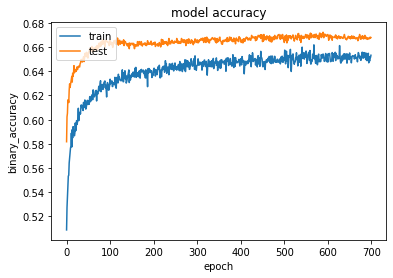

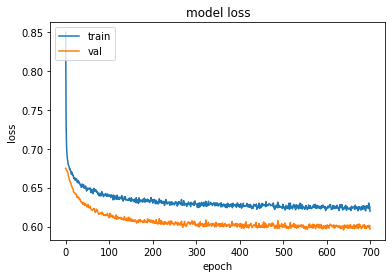

In [105]:
%tensorflow_version 2.x
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pickle

import numpy as np #better arrays in python, lepší práce s multidimenzionálními poli
import pandas as pd #data analytics tool, lepší manipulace s daty, dokáže například cut outnout column
import matplotlib.pyplot as plt #vizualizace tabulek a grafů
from IPython.display import clear_output #jen pro tenhle notebook
from six.moves import urllib
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import utils as np_utils
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import keras


#CSV_COLUMN_NAMES označuje nadpisy sloupců v csv soubour
CSV_COLUMN_NAMES=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg','Match_link','Result','team_one_name','team_two_name']
CSV_COLUMN_NAMES2=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg']



train=pd.read_csv('/content/pokus.csv',sep=";",names=CSV_COLUMN_NAMES,error_bad_lines=False,header=None)#vytvoří dataframe z našeho csv souboru
print(train.shape)#vypíše nám dimenzionalitu našeho dataframu (2, 3) 2 řádky 3 sloupce

#následující 2 řádky nám upraví dva sloupce z textových na číselné formáty (category datatype)
train['team_one_name']=pd.Categorical(train['team_one_name']).codes #sníží využití paměti z 1.2MB na 0.03 MB viz: https://towardsdatascience.com/staying-sane-while-adopting-pandas-categorical-datatypes-78dbd19dcd8a
train['team_two_name']=pd.Categorical(train['team_two_name']).codes

#Odstraním z dataframu následující sloupce (odkaz na zápas a jména týmů), jelikož jsem je využíval pouze při sběru dat
train.pop('Match_link')
train.pop('team_one_name')
train.pop('team_two_name')
#https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
#frac=1 znamená, vrať všechny řádky
train = train.sample(frac=1).reset_index(drop=True)

'''
train.pop('playerAAGrenadeDmg')
train.pop('playerABGrenadeDmg')
train.pop('playerACGrenadeDmg')
train.pop('playerADGrenadeDmg')
train.pop('playerAEGrenadeDmg')
train.pop('playerBAGrenadeDmg')
train.pop('playerBBGrenadeDmg')
train.pop('playerBCGrenadeDmg')
train.pop('playerBDGrenadeDmg')
train.pop('playerBEGrenadeDmg')

train.pop('playerAAKast')
train.pop('playerABKast')
train.pop('playerACKast')
train.pop('playerADKast')
train.pop('playerAEKast')
train.pop('playerBAKast')
train.pop('playerBBKast')
train.pop('playerBCKast')
train.pop('playerBDKast')
train.pop('playerBEKast')

train.pop('playerAAKD')
train.pop('playerABKD')
train.pop('playerACKD')
train.pop('playerADKD')
train.pop('playerAEKD')
train.pop('playerBAKD')
train.pop('playerBBKD')
train.pop('playerBCKD')
train.pop('playerBDKD')
train.pop('playerBEKD')

train.pop('playerAAAdr')
train.pop('playerABAdr')
train.pop('playerACAdr')
train.pop('playerADAdr')
train.pop('playerAEAdr')
train.pop('playerBAAdr')
train.pop('playerBBAdr')
train.pop('playerBCAdr')
train.pop('playerBDAdr')
train.pop('playerBEAdr')

train.pop('playerAADpr')
train.pop('playerABDpr')
train.pop('playerACDpr')
train.pop('playerADDpr')
train.pop('playerAEDpr')
train.pop('playerBADpr')
train.pop('playerBBDpr')
train.pop('playerBCDpr')
train.pop('playerBDDpr')
train.pop('playerBEDpr')

train.pop('playerAAKpr')
train.pop('playerABKpr')
train.pop('playerACKpr')
train.pop('playerADKpr')
train.pop('playerAEKpr')
train.pop('playerBAKpr')
train.pop('playerBBKpr')
train.pop('playerBCKpr')
train.pop('playerBDKpr')
train.pop('playerBEKpr')

train.pop('playerAAImpact')
train.pop('playerABImpact')
train.pop('playerACImpact')
train.pop('playerADImpact')
train.pop('playerAEImpact')
train.pop('playerBAImpact')
train.pop('playerBBImpact')
train.pop('playerBCImpact')
train.pop('playerBDImpact')
train.pop('playerBEImpact')

train.pop('playerAAHs')
train.pop('playerABHs')
train.pop('playerACHs')
train.pop('playerADHs')
train.pop('playerAEHs')
train.pop('playerBAHs')
train.pop('playerBBHs')
train.pop('playerBCHs')
train.pop('playerBDHs')
train.pop('playerBEHs')

train.pop('playerAARating')
train.pop('playerABRating')
train.pop('playerACRating')
train.pop('playerADRating')
train.pop('playerAERating')
train.pop('playerBARating')
train.pop('playerBBRating')
train.pop('playerBCRating')
train.pop('playerBDRating')
train.pop('playerBERating')
'''
#predictors nám vybere všechny sloupce, které jsou využity pro predikování výsledků neboli target_column
target_column = ['Result'] 

predictionScaler=StandardScaler()
y = train['Result'].values
train.pop('Result')
X = train.values

#predictionScaler.fit(scalerData)

#n = 100 # Max number of neighbours you want to consider
#param_grid = {'n_neighbors': np.arange(n)}
#grid = GridSearchCV(KNeighborsClassifier(), param_grid)
#grid.fit(X,y)
#print(grid.best_params_)


#určíme outliers (odlehlé hodnoty, které by mohly být při tréninku pro model škodlivé)
#zkráceně řečeno zjistíme odlehlou hodnotu tak, že ve svém okolí má oproti jiným hodnotám o dost méně "sousedů"
#5% dat 

lof = LocalOutlierFactor(contamination=0.1,n_neighbors=96)
yhat = lof.fit_predict(X)
mask = yhat != -1
X, y= X[mask, :], y[mask]
print(X.shape)

#rozdělíme náš dataframe na trénovací, testovací a validační dataset
#testovací dataset bude 15% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)#32 #888 887

#validační set bude 15% 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1875) # 0.11 x 0.9 = 0.1 podívat se na cross-validation


print(X_train.shape) 
print(X_test.shape)
print(X_val.shape) #součet odpovídá X.shape

#vytvoříme scaler, který nám data přetransformuje na formát lepší pro model ?
#scalujeme data aby si model nemyslel, že větší číselný řád indikuje větší důležitost atributu
#https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
#https://datascience.stackexchange.com/questions/43972/when-should-i-use-standardscaler-and-when-minmaxscaler

#nepoužíváme minmaxscaler, protože naše data by měly být "normálně" distribuovány

X_train = pd.DataFrame(X_train, columns=CSV_COLUMN_NAMES2)
X_test=pd.DataFrame(X_test, columns=CSV_COLUMN_NAMES2)
X_val=pd.DataFrame(X_val, columns=CSV_COLUMN_NAMES2)

predictionScaler.fit(X_train)

X_train=predictionScaler.transform(X_train)#fit transform na training data viz:https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data
X_test=predictionScaler.transform(X_test)
X_val=predictionScaler.transform(X_val)

#64 32
#data máme připravena, tak vytvoříme sequential model, jelikož potřebujeme mít více vrstev, ale máme pouze 1 input (zápas) a output 0;1
model = Sequential()
model.add(keras.layers.InputLayer(input_shape=(98)))#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
model.add(keras.layers.Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer=tf.initializers.lecun_uniform,bias_initializer=tf.initializers.lecun_normal))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_initializer=tf.initializers.lecun_uniform,bias_initializer=tf.initializers.lecun_normal))
model.add(keras.layers.Dropout(0.5))#50% inputů dropne abz se příliš nespoléhala na vybrané inputy
#jelikož děláme binární klasifikaci, tak aktivační funkce bude sigmoid popř. softmax, zde by mezi těmito dvěmi neměl být výkonově rozdíl viz:https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer
model.add(Dense(1, activation='sigmoid'))#menší než 0.5 = 0 a větší než 0.5 = 1


#tady jsem skončil s vysvětlováním!!!
#model zkompilujeme s parametry:
#Common values of [momentum] used in practice include .5, .9, and .99.
#optimizer bude ? optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.5)
#loss funkce bude BinaryCrossentropy, jelikož máme binární klasifikátor
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
              metrics=['binary_accuracy'])#metrics=['accuracy'] je to jedno accuracy se vnitřně přetransformuje na binary accuracy, kvůli binary crossentropy loss funkci
#metrics = ("accuracy")
#metrics=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.BinaryAccuracy(threshold=.7)])
#[tf.keras.metrics.BinaryAccuracy()]
#optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
#Adagrad(learning_rate=0.01) kolem 100 epochs a 32 batch_size je kolem 0.67

#shuffle=true?
history = model.fit(X_train, y_train, epochs=700,shuffle=True,batch_size=64,validation_data=(X_val, y_val))#validační data pro změny při tréninku sítě
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))#úspěšnost na trénovacím setu   


pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)# zkusit změnit verbose zde a nahoře na 1 a 2 mělo by to zobrazovat více údajů při tréninku
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))#úspěšnost na testovacím setu


plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('binary_accuracy')#'accuracy'
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#poznatky-vypadá to, že grenade damage každého hráče je nadbytečná a síť bez této informace vykazuje lepší výsledky!!
#optimální batch_size je 128 zjištěno zkoušením
#zatím nejlepší model měl 64 16 4 
#dense layers používají defaultně tf.initializers.glorot_uniform,ale pro můj model je přesnější glorot_normal


#kernel inity
#he_uniform>he_normal
#lecun uniform>lecun normal asi
#orthogonal a variance scaling použitelné

#bias inity
#lecun normal >he normal, variance_scaling
#https://www.tensorflow.org/api_docs/python/tf/keras/initializers


#zvýšil jsem dropout z 0.2 na 0.5, tak možná budu muset zvýšit learning_rate (*10 a zvýšit epochs na 1000), ale pokud budou vykazovat tu velkou mezeru, tak dropout snížit

In [19]:
#predictionScaler = pickle.load(open("scaler691.pkl", 'rb'))
Xnew=np.array([[1.36,3.0,39,296,0.65,0.0,0.549,0.5,1.2,0.65,0.73,1.28,85.3,0.77,0.48,1.19,7.5,1.11,0.59,0.73,1.12,68.2,0.68,0.29,1.16,2.5,1.08,0.63,0.72,1.03,72.8,0.67,0.55,1.07,5.2,1.05,0.62,0.73,0.91,71.1,0.65,0.54,1.05,5.6,1.01,0.66,0.71,0.95,73.5,0.61,0.47,0.93,9.1,0.89,0.79,0.62,1.13,70.6,0.56,0.44,0.71,4.7,0.87,0.81,0.6,0.95,70.7,0.69,0.61,0.85,4.4,0.86,0.75,0.65,0.72,66.2,0.71,0.35,0.94,1.8,0.83,0.73,0.69,0.66,65.0,0.58,0.5,0.80,1.0,0.74,0.75,0.54,0.65,69.3,0.48,0.48,0.64,6.7],
               [2.8,1.4,206,208,0.36,0.5,0.5,0.5,0.99,0.77,0.63,1.09,79.8,0.68,0.6,0.89,2.1,0.96,0.73,0.66,0.9,73.4,0.67,0.45,0.92,3.3,0.92,0.76,0.66,1.02,67.5,0.62,0.49,0.82,3.1,0.9,0.73,0.6,0.98,69.9,0.6,0.34,0.82,2.7,0.84,0.74,0.64,0.74,62.3,0.58,0.51,0.78,1.6,1.29,0.6,0.74,1.31,87.2,0.84,0.36,1.39,4.9,1.09,0.7,0.7,1.02,81.6,0.72,0.39,1.03,3.7,1.03,0.72,0.69,0.98,78.7,0.69,0.43,0.96,2.1,1.1366666666666667,0.6733333333333332,0.71,1.1033333333333333,82.5,0.75,0.3933333333333333,1.1266666666666667,3.566666666666667,1.1366666666666667,0.6733333333333332,0.71,1.1033333333333333,82.5,0.75,0.3933333333333333,1.1266666666666667,3.566666666666667],
               [1.5,2.4,77,112,0.4,0.47,0.5,0.5,1.34,0.67,0.74,1.54,90.3,0.89,0.32,1.33,6.6,1.07,0.6,0.73,0.91,72.6,0.69,0.47,1.16,2.6,0.97,0.69,0.7,0.86,72.5,0.59,0.38,0.86,6.6,0.91,0.63,0.66,0.77,65.3,0.54,0.47,0.86,5.0,0.86,0.65,0.62,0.79,63.1,0.56,0.52,0.87,7.0,1.03,0.64,0.71,0.94,71.4,0.65,0.47,1.01,5.3,1.02,0.69,0.7,1.03,71.9,0.64,0.44,0.93,8.7,1.01,0.68,0.72,0.92,71.9,0.64,0.49,0.93,5.7,1.0199999999999998,0.67,0.71,0.9633333333333334,71.73333333333333,0.6433333333333334,0.4666666666666666,0.9566666666666667,6.566666666666666,1.0199999999999998,0.67,0.71,0.9633333333333334,71.73333333333333,0.6433333333333334,0.4666666666666666,0.9566666666666667,6.566666666666666],
               [1.32,3.19,30,54,0.68,0.5,0.524,0.524,1.17,0.67,0.73,1.23,84.4,0.74,0.56,1.10,6.2,1.16,0.6,0.74,1.22,72.3,0.71,0.28,1.19,5.4,1.11,0.63,0.71,1.06,79.8,0.7,0.45,1.11,7.6,1.11,0.65,0.72,1.05,79.5,0.71,0.59,1.10,5.3,0.96,0.63,0.71,0.81,62.8,0.61,0.54,0.96,4.1,1.12,0.7,0.72,1.15,82.6,0.72,0.55,1.03,4.5,1.07,0.63,0.7,1.04,71.6,0.68,0.29,1.08,3.6,0.99,0.7,0.69,1.02,69.1,0.63,0.58,0.90,2.6,0.96,0.66,0.69,0.86,66.5,0.63,0.64,0.94,2.3,0.96,0.7,0.68,0.89,70.0,0.62,0.57,0.89,2.6],
               [2.38,1.53,78,103,0.48,0.55,0.583,0.5,1.16,0.72,0.69,1.27,87.0,0.8,0.49,1.12,4.8,1.07,0.56,0.73,0.91,66.9,0.65,0.33,1.16,2.4,1.0,0.66,0.71,0.89,70.6,0.62,0.44,0.94,3.9,0.98,0.7,0.67,1.01,72.0,0.62,0.55,0.88,3.8,1.0525,0.6599999999999999,0.7,1.02,74.125,0.6725000000000001,0.4525,1.0250000000000001,3.7249999999999996,1.18,0.66,0.73,1.22,82.6,0.77,0.5,1.17,7.6,1.14,0.66,0.72,1.23,79.5,0.7,0.52,1.06,5.0,1.13,0.6,0.76,0.98,73.3,0.71,0.24,1.19,3.8,1.04,0.62,0.71,0.9,73.8,0.65,0.59,1.04,4.5,0.91,0.72,0.66,0.98,63.7,0.6,0.43,0.83,4.6],
               [1.28,3.35,18,46,0.6,0.58,0.506,0.543,1.14,0.67,0.69,1.28,80.7,0.75,0.51,1.12,3.1,1.12,0.57,0.7,1.05,74.2,0.71,0.27,1.25,3.7,1.11,0.65,0.7,1.13,81.1,0.71,0.49,1.09,7.3,1.07,0.64,0.73,0.96,75.5,0.68,0.42,1.06,7.1,0.95,0.64,0.68,0.82,68.1,0.61,0.46,0.96,3.2,1.23,0.55,0.77,1.14,75.9,0.77,0.24,1.40,2.9,1.18,0.64,0.77,1.16,78.3,0.73,0.38,1.14,6.9,1.07,0.65,0.71,1.02,77.3,0.67,0.45,1.03,5.0,1.06,0.67,0.73,1.1,74.0,0.62,0.53,0.93,6.8,0.94,0.65,0.72,0.77,61.1,0.55,0.43,0.84,4.9],
               [2.25,1.57,34,45,0.55,0.4,0.46,0.5,1.2,0.63,0.74,1.15,84.4,0.79,0.53,1.25,4.8,1.16,0.6,0.72,1.17,76.6,0.73,0.33,1.21,4.3,1.05,0.73,0.69,1.14,78.8,0.67,0.58,0.93,5.9,1.03,0.63,0.74,0.87,69.3,0.66,0.46,1.04,3.2,0.84,0.7,0.65,0.76,60.2,0.54,0.43,0.77,3.9,1.02,0.68,0.68,1.03,70.7,0.65,0.55,0.96,4.0,1.13,0.67,0.67,1.29,77.0,0.78,0.3,1.16,0.9,1.01,0.65,0.68,0.96,70.9,0.66,0.56,1.01,3.2,1.0533333333333335,0.6666666666666666,0.6766666666666667,1.0933333333333335,72.86666666666666,0.6966666666666668,0.47000000000000003,1.0433333333333332,2.7000000000000006,1.0533333333333335,0.6666666666666666,0.6766666666666667,1.0933333333333335,72.86666666666666,0.6966666666666668,0.47000000000000003,1.0433333333333332,2.7000000000000006],
               [2.45,1.47,215,109,0.38,0.5,0.5,0.5,1.21,0.67,0.67,1.38,89.9,0.81,0.45,1.20,5.3,1.05,0.58,0.76,0.85,66.9,0.61,0.55,1.05,4.5,1.01,0.73,0.61,1.22,74.4,0.7,0.31,0.97,2.8,0.91,0.73,0.67,0.89,65.3,0.58,0.62,0.80,3.4,0.87,0.72,0.65,0.88,62.7,0.55,0.46,0.76,5.2,1.03,0.72,0.71,0.9,79.8,0.7,0.55,0.97,4.0,1.05,0.64,0.73,0.99,70.1,0.67,0.47,1.04,3.0,1.03,0.69,0.64,1.12,73.1,0.62,0.56,0.91,4.4,1.03,0.68,0.68,0.92,77.6,0.69,0.34,1.02,2.5,0.94,0.74,0.66,1.0,68.5,0.63,0.54,0.85,2.1],
               [1.33,2.93,42,66,0.46,0.47,0.45,0.49,1.12,0.63,0.71,1.1,77.5,0.72,0.53,1.14,3.0,1.07,0.64,0.7,1.09,73.5,0.67,0.56,1.05,5.6,1.06,0.62,0.7,1.05,70.0,0.67,0.3,1.08,3.0,1.01,0.7,0.69,1.02,74.7,0.62,0.45,0.88,5.4,1.0,0.63,0.72,0.87,68.0,0.61,0.47,0.98,3.7,1.17,0.67,0.72,1.17,85.0,0.78,0.54,1.16,3.1,1.12,0.67,0.71,1.2,75.4,0.73,0.32,1.10,1.8,1.12,0.68,0.69,1.21,79.8,0.74,0.48,1.09,5.8,0.96,0.7,0.68,0.86,71.5,0.63,0.52,0.90,4.8,1.0925,0.6799999999999999,0.7000000000000001,1.11,77.925,0.72,0.465,1.0625,3.875],
               [1.73,2.06,48,158,0.33,0.0,0.5,0.5,1.04,0.77,0.65,1.23,80.6,0.71,0.61,0.92,5.0,0.86,0.73,0.64,0.81,65.8,0.58,0.53,0.80,4.8,1.09,0.64,0.7,1.1,71.8,0.71,0.24,1.11,4.3,0.97,0.68,0.68,0.82,74.6,0.62,0.52,0.90,4.4,0.85,0.72,0.65,0.73,63.2,0.58,0.59,0.81,2.9,0.93,0.72,0.67,0.95,64.9,0.62,0.36,0.87,2.7,0.92,0.72,0.62,0.88,73.8,0.61,0.46,0.85,4.6,0.84,0.77,0.6,0.89,67.8,0.6,0.43,0.77,2.3,0.78,0.74,0.6,0.78,59.9,0.55,0.54,0.74,2.5,0.78,0.73,0.64,0.58,64.3,0.52,0.58,0.72,1.2]
               
])
Xnew = pd.DataFrame(Xnew, columns=CSV_COLUMN_NAMES2)
pokus=predictionScaler.transform(Xnew)
#model= keras.models.load_model("691model.h5")
ynew=(model.predict([pokus]))
#ynew=(model.predict_classes([Xnew]))
print(ynew)



#model= keras.models.load_model("686model.h5")


[[0.15663248]
 [0.6790366 ]
 [0.45727098]
 [0.24388596]
 [0.52646476]
 [0.40898696]
 [0.5545635 ]
 [0.6552319 ]
 [0.32695588]
 [0.41491243]]


pd.options.display.max_rows = 4000



In [ ]:
model.save('/content/save/691model.h5')
pickle.dump(predictionScaler, open("/content/save/scaler691.pkl", 'wb'))

In [ ]:
n = 100 # Max number of neighbours you want to consider
param_grid = {'n_neighbors': np.arange(n)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(X,y)
print(grid.best_params_)

In [ ]:
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)
pd.set_option("expand_frame_repr", True)
pd.set_option("large_repr", "info")
model.layers[0].get_weights()[0][98]



#print(X_val)
pokus=pd.read_csv('/content/pokus.csv',sep=";",names=CSV_COLUMN_NAMES,error_bad_lines=False,header=None)#vytvoří dataframe z našeho csv souboru
pokus.pop('Match_link')
pokus.pop('team_one_name')
pokus.pop('team_two_name')
pokus.pop('Result')


scaler=MinMaxScaler(feature_range=(0,1))
scaler.fit(pokus)
data=scaler.transform(pokus)
print(data)
